In [1]:
import math
import textwrap

import numpy as np
import pandas as pd

from sklearn import preprocessing as pre, pipeline
from sklearn import cluster, linear_model as lm
from sklearn import model_selection as ms, metrics

import walsdata
from walsdata import s229d, s280d
import langmap

In [138]:
import warnings
warnings.filterwarnings('ignore', 'The least populated class')

### Geographical groups

In [2]:
s229d.langs

,ID,Name,Macroarea,Latitude,Longitude,Glottocode,ISO639P3code,Family,Subfamily,Genus,ISO_codes,Samples_100,Samples_200,geometry
8,abk,Abkhaz,NaN,43.083333,41.000000,abkh1244,abk,Northwest Caucasian,NaN,Northwest Caucasian,abk,True,True,POINT (41.00000 43.08333)
34,aeg,Arabic (Egyptian),NaN,30.000000,31.000000,egyp1253,arz,Afro-Asiatic,NaN,Semitic,arz,True,True,POINT (31.00000 30.00000)
54,ain,Ainu,NaN,43.000000,143.000000,ainu1240,ain,NaN,NaN,NaN,ain,False,True,POINT (143.00000 43.00000)
66,akn,Akan,NaN,6.500000,-1.250000,akan1250,aka,Niger-Congo,NaN,Kwa,aka,False,False,POINT (-1.25000 6.50000)
70,ala,Alamblak,NaN,-4.666667,143.333333,alam1246,amp,Sepik,NaN,Sepik Hill,amp,True,True,POINT (143.33333 -4.66667)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2591,yko,Yukaghir (Kolyma),NaN,65.750000,150.833333,sout2750,yux,Yukaghir,NaN,Yukaghir,yux,False,True,POINT (150.83333 65.75000)
2609,yor,Yoruba,NaN,8.000000,4.333333,yoru1245,yor,Niger-Congo,Benue-Congo,Defoid,yor,True,True,POINT (4.33333 8.00000)
2620,yuc,Yuchi,NaN,35.750000,-86.750000,yuch1247,yuc,NaN,NaN,NaN,yuc,False,True,POINT (-86.75000 35.75000)
2625,yur,Yurok,NaN,41.333333,-124.000000,yuro1248,yur,Algic,NaN,Yurok,yur,False,True,POINT (-124.00000 41.33333)


In [3]:
dbscan = cluster.DBSCAN(metric='haversine', eps=0.12, min_samples=3)

In [4]:
labels = dbscan.fit_predict(s280d.langs[['Latitude', 'Longitude']].applymap(math.radians))

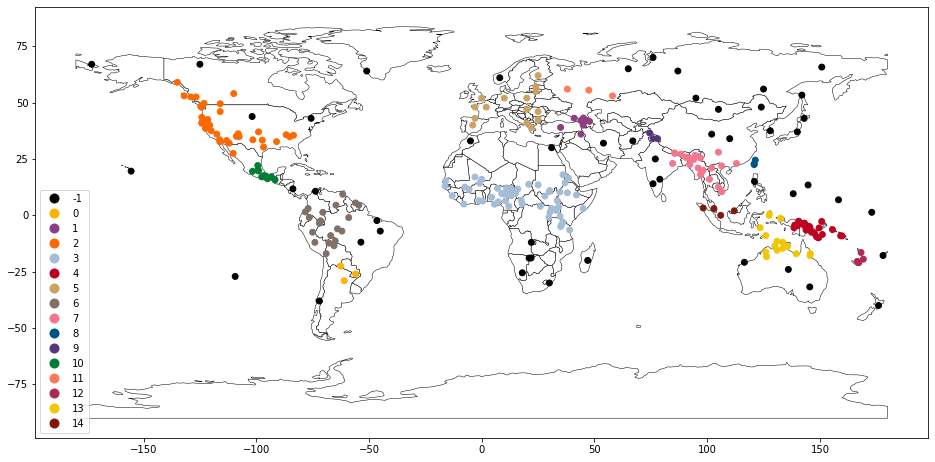

In [5]:
langmap.plot(s280d.langs, labels=labels)

In [6]:
labels

array([ 0,  1,  2, -1, -1,  3,  4,  5,  4,  3, -1,  6,  3, -1,  7,  6,  1,
        1,  4,  4,  8,  6,  6,  3,  3,  7,  2,  3,  3,  3, 14, -1,  5,  7,
       11,  5,  5,  9,  2,  6,  6, -1,  2, -1, 10, 11, 10,  2, -1,  7,  2,
        2,  6,  6,  4, -1,  2,  3,  3,  4,  3, 12, 13,  5,  6, -1,  3,  3,
       -1,  5,  5,  3,  3,  7,  3,  1,  5, 13,  3,  5, -1,  0,  2,  4,  3,
       -1, -1,  6,  7, 10,  5,  2, 10,  1, 12, 14,  3,  3,  3, -1,  4, 14,
        1,  3, 10,  7, -1, -1,  9, 13,  3,  3, -1,  4,  3, -1,  7, -1,  7,
        2,  4,  2,  4,  7, -1,  3,  3,  3,  2,  4, -1, -1,  1,  2,  3,  3,
        7, -1,  2,  4,  2,  7,  9,  7,  3,  5,  4, 12,  7,  1,  5, -1,  3,
        3, -1,  3,  3,  2, -1, -1, -1,  2, 13, 13,  7, -1, 13, -1,  2,  3,
        3,  3, -1,  2,  3,  7, 10, 13,  4,  2,  6,  7,  2, -1,  3, 10, -1,
        3,  3, -1,  3, -1, 13,  7, -1,  2,  3, 10,  8,  6, 12, -1,  5,  6,
       -1, -1,  2, 10,  2, -1, -1,  6,  5,  8, 11,  3,  3,  6, -1, 14,  6,
        4,  3,  5,  2,  4

In [55]:
region_names = {
    0: 'Paraguay',
    1: 'Caucasus',
    2: 'USA/Canada',
    3: 'Africa',
    4: 'New Guinea',
    5: 'Europe',
    6: 'Andes/Amazon',
    7: 'Southeast Asia',
    8: 'Taiwan',
    9: 'Pakistan',
    10: 'Mexico',
    11: 'West Russia',
    12: 'Melanesia',
    13: 'Australia',
    14: 'Indonesia/Malaysia',
}

### Getting families and regions ready for supervised learning

In [8]:
origins280 = s280d.langs[['ID', 'Family', 'Genus']].set_index('ID')
origins280.index.name = 'Language_ID'
origins280.columns = ['family', 'genus']
origins280['region'] = labels

In [9]:
origins280

,family,genus,region
Language_ID,,,
abi,Guaicuruan,South Guaicuruan,0
abk,Northwest Caucasian,Northwest Caucasian,1
aco,Keresan,Keresan,2
aeg,Afro-Asiatic,Semitic,-1
ain,NaN,NaN,-1
...,...,...,...
yur,Algic,Yurok,2
zan,Niger-Congo,Ubangi,3
zqc,Mixe-Zoque,Mixe-Zoque,10


In [10]:
origins229 = s229d.langs[['ID', 'Family', 'Genus']].set_index('ID')
origins229.index.name = 'Language_ID'
origins229.columns = ['family', 'genus']
origins229['region'] = origins280.region

In [11]:
origins229

,family,genus,region
Language_ID,,,
abk,Northwest Caucasian,Northwest Caucasian,1
aeg,Afro-Asiatic,Semitic,-1
ain,NaN,NaN,-1
akn,Niger-Congo,Kwa,3
ala,Sepik,Sepik Hill,4
...,...,...,...
yko,Yukaghir,Yukaghir,-1
yor,Niger-Congo,Defoid,3
yuc,NaN,NaN,2


Now I want to discard any groups that are too small to provide good estimates.

In [12]:
origins = origins280

In [13]:
min_group_size = 5

In [14]:
family_counts = origins.family.value_counts()

In [15]:
good_family_counts = family_counts[family_counts >= min_group_size]
good_family_counts

Austronesian         26
Niger-Congo          23
Indo-European        20
Afro-Asiatic         15
Sino-Tibetan         15
Trans-New Guinea     11
Altaic                8
Uto-Aztecan           6
Eastern Sudanic       6
Austro-Asiatic        6
Nakh-Daghestanian     5
Penutian              5
Pama-Nyungan          5
Name: family, dtype: int64

In [16]:
good_families = list(good_family_counts.index)

In [17]:
genus_counts = origins.genus.value_counts()

In [18]:
good_genus_counts = genus_counts[genus_counts >= min_group_size]
good_genus_counts

Oceanic    13
Bantoid     6
Name: genus, dtype: int64

In [19]:
good_genera = list(good_genus_counts.index)

In [20]:
region_counts = origins.region[origins.region >= 0].value_counts()

In [56]:
good_region_counts = region_counts[region_counts >= min_group_size]
good_region_counts

3     55
2     37
4     25
7     21
6     20
13    16
5     15
1     10
10    10
Name: region, dtype: int64

In [57]:
good_regions = sorted(list(good_region_counts.index))

In [58]:
good_region_names = [region_names[region] for region in good_regions]

In [24]:
origins_good = origins.copy()

In [25]:
origins_good.family = origins_good.family.where(
    origins_good.family.isin(good_families), np.nan
)
origins_good.genus = origins_good.genus.where(
    origins_good.genus.isin(good_genera), np.nan
)
origins_good.region = origins_good.region.where(
    origins_good.region.isin(good_regions), -1
)

In [26]:
origins_good

,family,genus,region
Language_ID,,,
abi,NaN,NaN,-1
abk,NaN,NaN,1
aco,NaN,NaN,2
aeg,Afro-Asiatic,NaN,-1
ain,NaN,NaN,-1
...,...,...,...
yur,NaN,NaN,2
zan,Niger-Congo,NaN,3
zqc,NaN,NaN,10


### Train-test split

In [27]:
values = s280d.values_scaled_imputed.reindex(origins_good.index)

In [28]:
values_train, values_test, origins_train, origins_test = (
    ms.train_test_split(values, origins_good, random_state=5312)
)

In [29]:
values_train

,1A,2A,3A,4A_2,4A_3,5A_1,5A_3,5A_4,6A_2,6A_3,...,143A_2,143A_3,143A_4,143A_6,143G_1,144A_1,144A_2,144A_3,144A_4,144A_5
Language_ID,,,,,,,,,,,,,,,,,,,,,
lah,0.75,1.0,0.50,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
anc,0.75,1.0,0.75,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
san,0.75,1.0,0.50,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
bur,1.00,0.5,1.00,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
iaa,1.00,1.0,0.50,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
asm,0.00,0.5,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
wic,0.50,0.0,0.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
yar,0.00,0.5,0.25,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [30]:
origins_train

,family,genus,region
Language_ID,,,
lah,Sino-Tibetan,NaN,7
anc,Afro-Asiatic,NaN,3
san,Niger-Congo,NaN,3
bur,NaN,NaN,-1
iaa,Austronesian,Oceanic,-1
...,...,...,...
asm,Trans-New Guinea,NaN,4
wic,NaN,NaN,2
yar,NaN,NaN,4


### Logistic regression on some features

In [31]:
def log_odds_vs_baseline(y_true, y_pred):
    """
    Custom metric for evaluating binary probability predictions.
    
    Like R^2, it goes from -infinity to 1, where a perfect
    model gets a score of 1, a baseline model gets a score
    of 0, and a maximally terrible model (one that assigns
    a probability of 0 to all the correct labels) gets a score of
    -infinity. Good models get some positive score less
    than one.
    
    This is computed as 1 - LL / LLB, where LL is the log
    loss and LLB is the log loss of the baseline model.
    """
    baseline_model = np.ones(y_true.shape) * np.sum(y_true, axis=0) / len(y_true)
    baseline_log_loss = metrics.log_loss(y_true, baseline_model)
    log_loss = metrics.log_loss(y_true, y_pred)
    return 1 - log_loss / baseline_log_loss

In [32]:
def origins_onehot(clf):
    onehot = pre.OneHotEncoder(
        categories=[good_families, good_genera, good_regions],
        handle_unknown='ignore',
    )

    model = pipeline.Pipeline([
        ('onehot', onehot),
        ('clf', clf),
    ])
    return model

In [153]:
def logistic_origins(feature, origins_train=origins_train):
    logreg = lm.LogisticRegression(random_state=5364)
    model = origins_onehot(logreg)
    return evaluate_lm(model, feature, origins_train=origins_train)

In [152]:
def evaluate_lm(model, feature, origins_train=origins_train):
    def force_binary(series):
        return series.round().astype(int)
    
    train = force_binary(values_train[feature])
    test = force_binary(values_test[feature])
    
    model.fit(origins_train, train)
    lm = model.named_steps['clf']
    
    train_score = log_odds_vs_baseline(train, model.predict_proba(origins_train))
    test_score = log_odds_vs_baseline(test, model.predict_proba(origins_test))
    intercept = lm.intercept_
    coefs = lm.coef_
    neutral_prob = lm.predict_proba(np.full(lm.coef_.shape, 0.0))[0, 1]
    train_prob = train[train == 1].count() / train.count()
    
    feature_name = walsdata.get_shortname(feature)
    
    result = OriginResults(
        feature_name=feature_name,
        train_score=train_score,
        test_score=test_score,
        observed_prob=train_prob,
        innate_prob=neutral_prob,
        coefs=coefs[0],
    )

    return result

In [35]:
class OriginResults:
    def __init__(
        self,
        feature_name,
        train_score,
        test_score,
        observed_prob,
        innate_prob,
        coefs,
    ):
        self.feature_name = feature_name
        self.train_score = train_score
        self.test_score = test_score
        self.observed_prob = observed_prob
        self.innate_prob = innate_prob
        self.coefs = dict(
            zip(good_families + good_genera + good_region_names, coefs)
        )
    
    def __str__(self):
        max_coef_name_len = max(len(coef_name) for coef_name in self.coefs)
        coef_display = '\n        '.join([
                f'{coef_name.ljust(max_coef_name_len)}: {coef_value:.3g}'
                for coef_name, coef_value in self.coefs.items()
        ])
        return textwrap.dedent(
            f"""\
            Feature {self.feature_name}:
                Training score: {self.train_score:.3g}
                Testing score: {self.test_score:.3g}
                Observed rate: {self.observed_prob:.3g}
                Inferred innate rate: {self.innate_prob:.3g}
                Coefficients:
            """
        ) + '        ' + coef_display
    
    def __repr__(self):
        return str(self)

In [60]:
logistic_origins('81A_1')

Feature order__sov:
    Training score: 0.349
    Testing score: 0.203
    Observed rate: 0.41
    Inferred innate rate: 0.497
    Coefficients:
        Austronesian     : -1.95
        Niger-Congo      : -1.69
        Indo-European    : -0.399
        Afro-Asiatic     : -0.0936
        Sino-Tibetan     : 0.529
        Trans-New Guinea : 0.956
        Altaic           : 1.37
        Uto-Aztecan      : 0.554
        Eastern Sudanic  : -0.99
        Austro-Asiatic   : -0.827
        Nakh-Daghestanian: 0.527
        Penutian         : -0.483
        Pama-Nyungan     : -0.375
        Oceanic          : -0.98
        Bantoid          : -0.377
        Caucasus         : 0.514
        USA/Canada       : -0.367
        Africa           : -0.395
        New Guinea       : 1.41
        Europe           : -1.29
        Andes/Amazon     : 0.329
        Southeast Asia   : -0.193
        Mexico           : -1.52
        Australia        : -1.25

In [61]:
logistic_origins('81A_2')

Feature order__svo:
    Training score: 0.326
    Testing score: 0.24
    Observed rate: 0.314
    Inferred innate rate: 0.217
    Coefficients:
        Austronesian     : 0.364
        Niger-Congo      : 2.23
        Indo-European    : 0.427
        Afro-Asiatic     : 0.541
        Sino-Tibetan     : -0.024
        Trans-New Guinea : -0.816
        Altaic           : -0.757
        Uto-Aztecan      : 0.323
        Eastern Sudanic  : -0.459
        Austro-Asiatic   : 0.574
        Nakh-Daghestanian: -0.217
        Penutian         : -0.223
        Pama-Nyungan     : -0.018
        Oceanic          : 0.766
        Bantoid          : 0.542
        Caucasus         : -0.604
        USA/Canada       : -1.56
        Africa           : 0.856
        New Guinea       : -0.426
        Europe           : 1.63
        Andes/Amazon     : -0.383
        Southeast Asia   : 0.901
        Mexico           : 0.47
        Australia        : 0.795

In [62]:
logistic_origins('81A_3')

Feature order__vso:
    Training score: 0.242
    Testing score: -0.407
    Observed rate: 0.0857
    Inferred innate rate: 0.063
    Coefficients:
        Austronesian     : 1.4
        Niger-Congo      : -0.639
        Indo-European    : -0.363
        Afro-Asiatic     : 0.0151
        Sino-Tibetan     : -0.364
        Trans-New Guinea : -0.236
        Altaic           : -0.318
        Uto-Aztecan      : -0.482
        Eastern Sudanic  : 1.57
        Austro-Asiatic   : -0.132
        Nakh-Daghestanian: -0.0938
        Penutian         : 0.155
        Pama-Nyungan     : -0.186
        Oceanic          : 0.262
        Bantoid          : -0.134
        Caucasus         : -0.219
        USA/Canada       : 0.95
        Africa           : 0.213
        New Guinea       : -0.887
        Europe           : -0.286
        Andes/Amazon     : -0.557
        Southeast Asia   : -0.395
        Mexico           : 0.907
        Australia        : -0.685

In [63]:
logistic_origins('81A_4')

Feature order__vos:
    Training score: 0.282
    Testing score: 0.0256
    Observed rate: 0.0238
    Inferred innate rate: 0.0219
    Coefficients:
        Austronesian     : 0.363
        Niger-Congo      : -0.189
        Indo-European    : -0.168
        Afro-Asiatic     : -0.163
        Sino-Tibetan     : -0.175
        Trans-New Guinea : -0.147
        Altaic           : -0.133
        Uto-Aztecan      : -0.167
        Eastern Sudanic  : -0.0629
        Austro-Asiatic   : -0.0553
        Nakh-Daghestanian: -0.0386
        Penutian         : -0.0691
        Pama-Nyungan     : -0.0926
        Oceanic          : -0.268
        Bantoid          : -0.0556
        Caucasus         : -0.0931
        USA/Canada       : -0.401
        Africa           : -0.503
        New Guinea       : -0.354
        Europe           : -0.133
        Andes/Amazon     : 0.477
        Southeast Asia   : -0.191
        Mexico           : 1.94
        Australia        : 0.497

In [64]:
logistic_origins('81A_5')

Feature order__ovs:
    Training score: 0.208
    Testing score: 0.118
    Observed rate: 0.0143
    Inferred innate rate: 0.014
    Coefficients:
        Austronesian     : -0.298
        Niger-Congo      : -0.141
        Indo-European    : -0.117
        Afro-Asiatic     : -0.12
        Sino-Tibetan     : -0.123
        Trans-New Guinea : -0.109
        Altaic           : -0.0891
        Uto-Aztecan      : -0.052
        Eastern Sudanic  : -0.0463
        Austro-Asiatic   : -0.0372
        Nakh-Daghestanian: -0.0257
        Penutian         : -0.0501
        Pama-Nyungan     : -0.087
        Oceanic          : -0.107
        Bantoid          : -0.0397
        Caucasus         : -0.0627
        USA/Canada       : -0.29
        Africa           : -0.374
        New Guinea       : -0.242
        Europe           : -0.0926
        Andes/Amazon     : 0.615
        Southeast Asia   : -0.134
        Mexico           : -0.101
        Australia        : 1.36

In [65]:
logistic_origins('19A_5')

Feature present__th_sounds:
    Training score: 0.157
    Testing score: 0.0446
    Observed rate: 0.11
    Inferred innate rate: 0.0991
    Coefficients:
        Austronesian     : 0.758
        Niger-Congo      : -0.402
        Indo-European    : 0.293
        Afro-Asiatic     : -0.73
        Sino-Tibetan     : 0.303
        Trans-New Guinea : -0.311
        Altaic           : 0.203
        Uto-Aztecan      : -0.458
        Eastern Sudanic  : 0.284
        Austro-Asiatic   : -0.271
        Nakh-Daghestanian: -0.125
        Penutian         : -0.318
        Pama-Nyungan     : 0.475
        Oceanic          : 0.377
        Bantoid          : 0.528
        Caucasus         : -0.373
        USA/Canada       : -0.164
        Africa           : 0.134
        New Guinea       : -1.02
        Europe           : 0.49
        Andes/Amazon     : -0.218
        Southeast Asia   : 0.245
        Mexico           : 1.48
        Australia        : -0.791

### Finding the best regularization penalty

In [158]:
def logistic_origins_cv(feature, origins_train=origins_train):
    logreg = lm.LogisticRegressionCV(
        random_state=5364, scoring='neg_log_loss',
        Cs=[0.2, 0.3, 0.5, 0.8, 1, 1.5, 2]
    )
    model = origins_onehot(logreg)
    try:
        return evaluate_lm(model, feature, origins_train=origins_train)
    except ValueError:
        return logistic_origins(feature, origins_train=origins_train)

In [116]:
logistic_origins_cv('81A_1')

Feature order__sov:
    Training score: 0.388
    Testing score: 0.211
    Observed rate: 0.41
    Inferred innate rate: 0.527
    Coefficients:
        Austronesian     : -2.49
        Niger-Congo      : -2.26
        Indo-European    : -0.38
        Afro-Asiatic     : -0.238
        Sino-Tibetan     : 0.61
        Trans-New Guinea : 1.18
        Altaic           : 1.76
        Uto-Aztecan      : 0.791
        Eastern Sudanic  : -1.49
        Austro-Asiatic   : -1.24
        Nakh-Daghestanian: 0.783
        Penutian         : -0.623
        Pama-Nyungan     : -0.56
        Oceanic          : -1.2
        Bantoid          : -0.465
        Caucasus         : 0.521
        USA/Canada       : -0.52
        Africa           : -0.359
        New Guinea       : 1.58
        Europe           : -1.83
        Andes/Amazon     : 0.261
        Southeast Asia   : -0.336
        Mexico           : -2.12
        Australia        : -1.61

In [117]:
logistic_origins_cv('81A_2')

Feature order__svo:
    Training score: 0.354
    Testing score: 0.227
    Observed rate: 0.314
    Inferred innate rate: 0.2
    Coefficients:
        Austronesian     : 0.352
        Niger-Congo      : 2.82
        Indo-European    : 0.291
        Afro-Asiatic     : 0.693
        Sino-Tibetan     : -0.133
        Trans-New Guinea : -1.14
        Altaic           : -1.04
        Uto-Aztecan      : 0.606
        Eastern Sudanic  : -0.555
        Austro-Asiatic   : 0.768
        Nakh-Daghestanian: -0.3
        Penutian         : -0.258
        Pama-Nyungan     : -0.00279
        Oceanic          : 0.967
        Bantoid          : 0.644
        Caucasus         : -0.827
        USA/Canada       : -1.99
        Africa           : 0.871
        New Guinea       : -0.384
        Europe           : 2.17
        Andes/Amazon     : -0.38
        Southeast Asia   : 1.16
        Mexico           : 0.624
        Australia        : 0.994

In [118]:
logistic_origins_cv('81A_3')

Feature order__vso:
    Training score: 0.29
    Testing score: -0.351
    Observed rate: 0.0857
    Inferred innate rate: 0.0539
    Coefficients:
        Austronesian     : 1.82
        Niger-Congo      : -0.863
        Indo-European    : -0.501
        Afro-Asiatic     : 0.132
        Sino-Tibetan     : -0.495
        Trans-New Guinea : -0.274
        Altaic           : -0.465
        Uto-Aztecan      : -0.816
        Eastern Sudanic  : 2.18
        Austro-Asiatic   : -0.197
        Nakh-Daghestanian: -0.139
        Penutian         : 0.144
        Pama-Nyungan     : -0.278
        Oceanic          : 0.144
        Bantoid          : -0.176
        Caucasus         : -0.319
        USA/Canada       : 1.24
        Africa           : 0.204
        New Guinea       : -1.24
        Europe           : -0.393
        Andes/Amazon     : -0.771
        Southeast Asia   : -0.532
        Mexico           : 1.33
        Australia        : -1.05

In [119]:
logistic_origins_cv('81A_4')

Feature order__vos:
    Training score: 0.367
    Testing score: 0.0321
    Observed rate: 0.0238
    Inferred innate rate: 0.0174
    Coefficients:
        Austronesian     : 0.653
        Niger-Congo      : -0.248
        Indo-European    : -0.239
        Afro-Asiatic     : -0.217
        Sino-Tibetan     : -0.244
        Trans-New Guinea : -0.195
        Altaic           : -0.197
        Uto-Aztecan      : -0.37
        Eastern Sudanic  : -0.0836
        Austro-Asiatic   : -0.0817
        Nakh-Daghestanian: -0.0576
        Penutian         : -0.0933
        Pama-Nyungan     : -0.156
        Oceanic          : -0.458
        Bantoid          : -0.077
        Caucasus         : -0.137
        USA/Canada       : -0.539
        Africa           : -0.66
        New Guinea       : -0.489
        Europe           : -0.189
        Andes/Amazon     : 0.829
        Southeast Asia   : -0.266
        Mexico           : 2.72
        Australia        : 0.813

In [120]:
logistic_origins_cv('81A_5')

/Users/gthill/Library/Caches/pypoetry/virtualenvs/sils-bV3__HrQ-py3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Feature order__ovs:
    Training score: 0.208
    Testing score: 0.118
    Observed rate: 0.0143
    Inferred innate rate: 0.014
    Coefficients:
        Austronesian     : -0.298
        Niger-Congo      : -0.141
        Indo-European    : -0.117
        Afro-Asiatic     : -0.12
        Sino-Tibetan     : -0.123
        Trans-New Guinea : -0.109
        Altaic           : -0.0891
        Uto-Aztecan      : -0.052
        Eastern Sudanic  : -0.0463
        Austro-Asiatic   : -0.0372
        Nakh-Daghestanian: -0.0257
        Penutian         : -0.0501
        Pama-Nyungan     : -0.087
        Oceanic          : -0.107
        Bantoid          : -0.0397
        Caucasus         : -0.0627
        USA/Canada       : -0.29
        Africa           : -0.374
        New Guinea       : -0.242
        Europe           : -0.0926
        Andes/Amazon     : 0.615
        Southeast Asia   : -0.134
        Mexico           : -0.101
        Australia        : 1.36

In [121]:
logistic_origins_cv('19A_5')

Feature present__th_sounds:
    Training score: 0.0712
    Testing score: -0.0232
    Observed rate: 0.11
    Inferred innate rate: 0.11
    Coefficients:
        Austronesian     : 0.332
        Niger-Congo      : -0.117
        Indo-European    : 0.128
        Afro-Asiatic     : -0.227
        Sino-Tibetan     : 0.114
        Trans-New Guinea : -0.149
        Altaic           : 0.042
        Uto-Aztecan      : -0.103
        Eastern Sudanic  : 0.085
        Austro-Asiatic   : -0.0659
        Nakh-Daghestanian: -0.0388
        Penutian         : -0.0901
        Pama-Nyungan     : 0.108
        Oceanic          : 0.209
        Bantoid          : 0.114
        Caucasus         : -0.102
        USA/Canada       : -0.133
        Africa           : -0.0352
        New Guinea       : -0.381
        Europe           : 0.174
        Andes/Amazon     : -0.102
        Southeast Asia   : 0.0933
        Mexico           : 0.526
        Australia        : -0.249

### Logistic regression baseline on all features

Similar to my scrambled clustering baseline, this is logistic regression of all categorical features based on a scrambled table of families and regions. This should give an idea of how many "good" models will show up just by chance.

In [42]:
cat_features = list(values.columns[values.columns.str.contains('_')])

In [144]:
def pandify(origin_results):
    features, origin_results = zip(*origin_results)
    df = pd.DataFrame(index=map(walsdata.get_shortname, features))
    df['training_score'] = [result.train_score for result in origin_results]
    df['testing_score'] = [result.test_score for result in origin_results]
    df['observed_rate'] = [result.observed_prob for result in origin_results]
    df['innate_rate'] = [result.innate_prob for result in origin_results]
    for coef in origin_results[0].coefs:
        df[coef] = [result.coefs[coef] for result in origin_results]
    return df

In [157]:
def logistic_origins_all(origins_train=origins_train, cv=False):
    result = []
    for feature in cat_features:
        try:
            if cv:
                result.append((feature, logistic_origins_cv(feature, origins_train=origins_train)))
            else:
                result.append((feature, logistic_origins(feature, origins_train=origins_train)))
        except ValueError:
            # Feature missing from the training set
            pass
    return pandify(result)

In [150]:
origins_train_scrambled = origins_train.copy()
state = np.random.RandomState(280)
for col in origins_train_scrambled:
    origins_train_scrambled[col] = state.permutation(origins_train_scrambled[col].values)

In [151]:
origins_train_scrambled

,family,genus,region
Language_ID,,,
lah,Sino-Tibetan,Oceanic,6
anc,NaN,NaN,2
san,NaN,NaN,3
bur,NaN,Oceanic,-1
iaa,NaN,NaN,6
...,...,...,...
asm,NaN,NaN,2
wic,Niger-Congo,NaN,2
yar,Sino-Tibetan,Oceanic,-1


In [159]:
logistic_origins_all(origins_train=origins_train_scrambled)

,training_score,testing_score,observed_rate,innate_rate,Austronesian,Niger-Congo,Indo-European,Afro-Asiatic,Sino-Tibetan,Trans-New Guinea,...,Bantoid,Caucasus,USA/Canada,Africa,New Guinea,Europe,Andes/Amazon,Southeast Asia,Mexico,Australia
voicing__plosives,0.087945,-0.074393,0.609524,0.678487,0.048606,-0.312410,-0.403905,0.573397,-0.313562,0.141690,...,0.085767,-1.058593,-0.874852,0.096776,-0.698394,-0.785669,-0.045008,-0.370012,-0.475541,0.439060
voicing__fricatives,0.060198,-0.197068,0.338095,0.338395,-0.240851,-0.299913,-0.401060,0.078525,0.714170,0.391810,...,0.345214,-0.363484,0.202266,-0.048041,-0.278191,-0.320915,0.690243,0.516996,-0.134446,-0.372525
plosive_gap__other,0.088928,-0.068017,0.428571,0.352555,-0.023731,0.166689,0.509767,-0.675801,0.218945,0.034620,...,-0.161354,1.013223,0.868078,-0.117462,0.879580,0.697751,0.190524,0.285996,0.706114,-0.234660
plosive_gap__p,0.145817,0.055372,0.076190,0.071453,0.541220,0.030102,-0.382953,-0.473713,0.018166,1.194218,...,0.547896,-0.308440,-0.056032,0.109999,-0.957143,-0.525581,-0.143516,-0.586901,-0.453957,-0.013532
plosive_gap__g,0.140279,-0.202925,0.076190,0.091768,-0.827820,-0.164410,-0.493028,0.478278,-0.514780,-0.556650,...,-0.249978,0.305554,-0.102160,0.124840,0.058816,-0.401219,-0.731862,-0.650932,-0.399795,-0.595066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
negative_word__initial,0.091624,-0.017062,0.085714,0.067586,0.788652,0.343752,0.144806,-0.010119,0.094859,0.138676,...,0.469779,-0.318478,-0.029005,0.393131,-0.374860,-0.429203,-0.650271,0.540858,0.226425,0.832166
negative_word__final,0.099977,-0.111837,0.090476,0.072512,0.009667,0.170939,0.608139,-0.665323,-0.649625,-0.017672,...,-0.247100,-0.269689,0.847081,0.006180,0.336366,0.294754,-0.648459,0.638963,-0.450433,0.421613
negative_word__second,0.111056,-0.156981,0.147619,0.127028,0.169379,-1.001944,-0.787444,0.424822,0.574201,-0.292615,...,0.243097,0.654984,-0.167589,0.516400,0.607757,0.011178,0.016816,-0.274602,0.110885,0.158679
negative_word__other,0.186145,-0.116538,0.061905,0.052491,-0.670653,0.053905,-0.382443,-0.460235,0.214287,0.203073,...,0.589544,-0.308282,-0.243331,0.167740,0.208414,0.377481,0.160047,0.143741,0.334419,-0.447960


In [160]:
logistic_origins_all(origins_train=origins_train_scrambled, cv=True)

,training_score,testing_score,observed_rate,innate_rate,Austronesian,Niger-Congo,Indo-European,Afro-Asiatic,Sino-Tibetan,Trans-New Guinea,...,Bantoid,Caucasus,USA/Canada,Africa,New Guinea,Europe,Andes/Amazon,Southeast Asia,Mexico,Australia
voicing__plosives,0.051274,-0.009042,0.609524,0.631658,0.042495,-0.175221,-0.154214,0.263487,-0.118063,0.055331,...,0.062109,-0.346442,-0.469846,0.179975,-0.364949,-0.288442,0.054197,-0.090083,-0.149749,0.242576
voicing__fricatives,0.033646,-0.096620,0.338095,0.338619,-0.145688,-0.160587,-0.176627,0.055325,0.312015,0.176333,...,0.112234,-0.114677,0.135689,-0.017175,-0.184700,-0.113175,0.353729,0.250774,-0.081136,-0.172142
plosive_gap__other,0.054159,-0.003584,0.428571,0.404711,-0.027345,0.100047,0.218155,-0.319249,0.068253,0.022197,...,-0.086532,0.320291,0.464269,-0.208042,0.465028,0.246862,0.005339,0.039768,0.247853,-0.167581
plosive_gap__p,0.102161,0.040082,0.076190,0.073391,0.378590,-0.014655,-0.245204,-0.311132,0.022164,0.785451,...,0.307095,-0.168062,-0.036875,0.116557,-0.598623,-0.284436,-0.078521,-0.345742,-0.258684,-0.000893
plosive_gap__g,0.169054,-0.224056,0.076190,0.096397,-1.029497,-0.205848,-0.644445,0.563930,-0.663016,-0.724248,...,-0.341779,0.334210,-0.135891,0.101243,0.054509,-0.531186,-0.977545,-0.861952,-0.527724,-0.772448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
negative_word__initial,0.038835,-0.013223,0.085714,0.080019,0.320589,0.109066,0.032819,-0.013162,0.015632,0.020515,...,0.120917,-0.079806,-0.043416,0.177189,-0.152377,-0.120203,-0.208238,0.169264,0.058176,0.311134
negative_word__final,0.039158,-0.086756,0.090476,0.085760,0.004710,0.077647,0.189607,-0.198370,-0.177654,-0.001442,...,-0.064993,-0.077708,0.349250,-0.069870,0.124034,0.058573,-0.214706,0.169746,-0.127576,0.139204
negative_word__second,0.047470,-0.039000,0.147619,0.139718,0.087913,-0.352234,-0.241965,0.170135,0.214971,-0.101567,...,0.070539,0.216971,-0.108957,0.291208,0.227531,-0.016312,-0.018238,-0.110720,-0.005732,0.032643
negative_word__other,0.165842,-0.100075,0.061905,0.054724,-0.592673,0.035101,-0.332057,-0.402313,0.180620,0.169200,...,0.494471,-0.246003,-0.230958,0.144881,0.189811,0.317388,0.121343,0.127676,0.287530,-0.390101


### Logistic regression on all categorical features

In [161]:
logistic_origins_all()

,training_score,testing_score,observed_rate,innate_rate,Austronesian,Niger-Congo,Indo-European,Afro-Asiatic,Sino-Tibetan,Trans-New Guinea,...,Bantoid,Caucasus,USA/Canada,Africa,New Guinea,Europe,Andes/Amazon,Southeast Asia,Mexico,Australia
voicing__plosives,0.215333,0.217916,0.609524,0.532592,0.687813,0.484572,0.714279,1.068457,0.114976,-0.254407,...,-0.649601,0.317663,-0.330213,1.644720,0.034454,1.101001,0.215423,0.331299,-0.075246,-1.041782
voicing__fricatives,0.324724,0.204845,0.338095,0.334492,-0.043899,0.933139,1.529108,1.063894,0.902493,-0.868859,...,0.920108,1.206065,-1.858368,0.086788,-0.899518,1.189401,-0.242519,0.004408,-0.221265,-1.386608
plosive_gap__other,0.242842,0.217416,0.428571,0.487654,-0.689765,-0.506480,-0.785317,-1.091406,-0.152264,0.189643,...,0.632256,0.015901,0.502108,-1.699161,0.345591,-1.112519,-0.066376,-0.367477,0.331397,0.983867
plosive_gap__p,0.255350,0.350595,0.076190,0.047337,-0.551027,-0.142977,-0.299031,1.306412,-0.302584,0.533975,...,0.471872,-0.175790,-0.670329,1.283814,0.595670,-0.235752,-0.457356,-0.328668,-0.284370,-0.381281
plosive_gap__g,0.128042,-0.244989,0.076190,0.064975,-0.090980,0.222917,-0.370693,-0.381388,-0.012717,0.085253,...,-0.209149,-0.224151,0.385357,-0.558406,0.181127,-0.291578,0.868585,1.350546,0.288093,0.101795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
negative_word__initial,0.246078,0.232446,0.085714,0.069296,1.467514,-0.491181,-0.386604,0.195197,-0.386376,-0.259612,...,-0.129962,-0.235188,0.715309,-0.383798,-0.865565,-0.303948,-0.020091,-0.418297,1.730490,-0.195699
negative_word__final,0.128638,-0.180712,0.090476,0.065046,0.069360,0.123265,-0.370859,0.929482,0.478536,0.497002,...,-0.308376,-0.224329,-0.808183,0.647389,0.324857,-0.291701,0.012656,0.425590,-0.363205,0.976996
negative_word__second,0.191692,0.124703,0.147619,0.116886,0.002670,0.082131,0.380476,-0.989405,-0.163929,-0.483911,...,-0.450897,-0.392846,-0.736048,0.588408,-0.572665,1.458066,-0.317918,0.908802,0.004455,1.140884
negative_word__other,0.110223,-0.069739,0.061905,0.067158,-0.660966,-0.435737,-0.377971,0.267178,0.465688,0.445735,...,-0.124829,-0.259307,0.013705,-0.559788,0.380914,-0.297966,-0.580732,0.412163,-0.396974,-0.484361


In [162]:
logistic_origins_all(cv=True)

,training_score,testing_score,observed_rate,innate_rate,Austronesian,Niger-Congo,Indo-European,Afro-Asiatic,Sino-Tibetan,Trans-New Guinea,...,Bantoid,Caucasus,USA/Canada,Africa,New Guinea,Europe,Andes/Amazon,Southeast Asia,Mexico,Australia
voicing__plosives,0.230145,0.227161,0.609524,0.516163,0.916668,0.586925,0.790198,1.291865,0.136808,-0.289006,...,-0.848300,0.347782,-0.281664,1.794395,0.112403,1.343823,0.287732,0.397272,-0.034114,-1.140772
voicing__fricatives,0.354336,0.202268,0.338095,0.334018,0.058990,1.079869,1.904107,1.292848,1.173016,-1.194860,...,1.278994,1.602658,-2.326631,-0.019141,-0.972430,1.493749,-0.275127,-0.179934,-0.260618,-1.844607
plosive_gap__other,0.257008,0.225132,0.428571,0.498644,-0.913097,-0.603436,-0.868065,-1.310855,-0.166618,0.197240,...,0.833266,0.032477,0.480354,-1.835920,0.316449,-1.342241,-0.108715,-0.424177,0.335175,1.093709
plosive_gap__p,0.255350,0.350592,0.076190,0.047338,-0.551028,-0.143032,-0.299049,1.306424,-0.302587,0.533967,...,0.471813,-0.175808,-0.670339,1.283799,0.595654,-0.235765,-0.457386,-0.328685,-0.284399,-0.381315
plosive_gap__g,0.058933,-0.186327,0.076190,0.075469,-0.086419,0.007190,-0.125188,-0.139362,0.129477,0.025004,...,-0.051427,-0.067404,0.124861,-0.272636,0.031996,-0.099461,0.301768,0.487427,0.069583,0.006831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
negative_word__initial,0.301680,0.269972,0.085714,0.058149,1.935934,-0.622211,-0.523708,0.463479,-0.515633,-0.306998,...,-0.171803,-0.335167,1.044484,-0.549968,-1.166278,-0.410308,0.094179,-0.554015,2.293388,-0.298504
negative_word__final,0.120881,-0.170482,0.090476,0.067506,0.062016,0.103642,-0.328681,0.858294,0.429932,0.441443,...,-0.257783,-0.195336,-0.728486,0.612343,0.297818,-0.258887,-0.005714,0.382589,-0.316127,0.869865
negative_word__second,0.191692,0.124700,0.147619,0.116883,0.002667,0.082119,0.380553,-0.989406,-0.163902,-0.483894,...,-0.450818,-0.392829,-0.736010,0.588408,-0.572625,1.458071,-0.317828,0.908778,0.004500,1.140950
negative_word__other,0.062505,-0.046763,0.061905,0.064392,-0.298875,-0.199364,-0.153192,0.083216,0.270260,0.257502,...,-0.053527,-0.088023,0.034586,-0.289242,0.262856,-0.121582,-0.232713,0.249633,-0.138855,-0.195877
